In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns

from math import sqrt 
from statsmodels.tsa.mar_model import MAR

import pylab
pylab.rcParams['figure.figsize'] = (10, 6)

In [3]:
# Model Setup
order = 1
nstates = 2

switch_ar = False
switch_sd = False
switch_mean = True

In [4]:
# Load my dataset

dir = '/Users/mrefermat/git/FinancePhD/Empirical Methods/'
file1 = 'Copy of PredictorData2014.xlsx'
file2 = 'measurestailrisk.xlsx'
file3 = 'VRPtable.txt'
tail_data = pd.read_excel(dir+file2,parse_dates=[[0,1]],index_col=0).resample(rule='m',how='last')
vol = pd.read_csv(dir+file3,delim_whitespace=True,parse_dates=[[0,1]],index_col=0).resample(rule='m',how='last')
pred = pd.read_excel(dir+file1,sheetname='Monthly',parse_dates=[[0,1]],index_col=0).resample(rule='m',how='last')

Optimization terminated successfully.
         Current function value: 0.947281
         Iterations: 56
         Function evaluations: 65
         Gradient evaluations: 65
Parameter Estimates forHellinger Tail Risk 1
-------------------
Transition probabilities:
[[ 0.96853908  0.69216249]
 [ 0.03146092  0.30783751]]
Standard Deviation (non-switching, here)
2.37206755538
1.85459551076
Means (switching)
('- in state 1:', -0.11920494078553899)
('- in state 2:', 2.6127162489961591)
Optimization terminated successfully.
         Current function value: 1.023294
         Iterations: 52
         Function evaluations: 71
         Gradient evaluations: 71
Parameter Estimates forHellinger Tail Risk 2
-------------------
Transition probabilities:
[[ 0.973821   0.5910408]
 [ 0.026179   0.4089592]]
Standard Deviation (non-switching, here)
2.37120420624
2.04428830843
Means (switching)
('- in state 1:', -0.10187166432567067)
('- in state 2:', 2.3784325342678398)
Optimization terminated successfully.


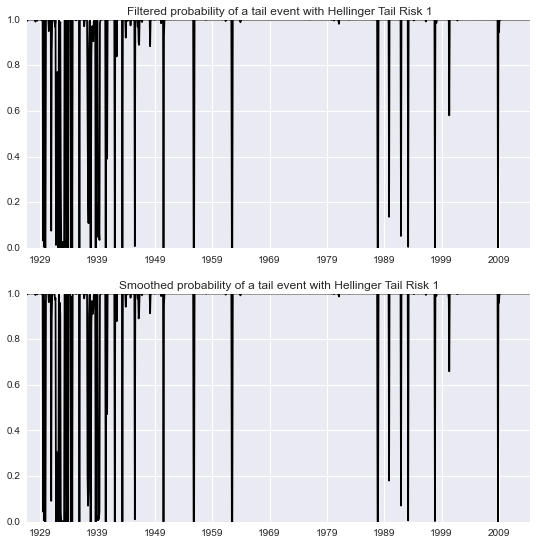

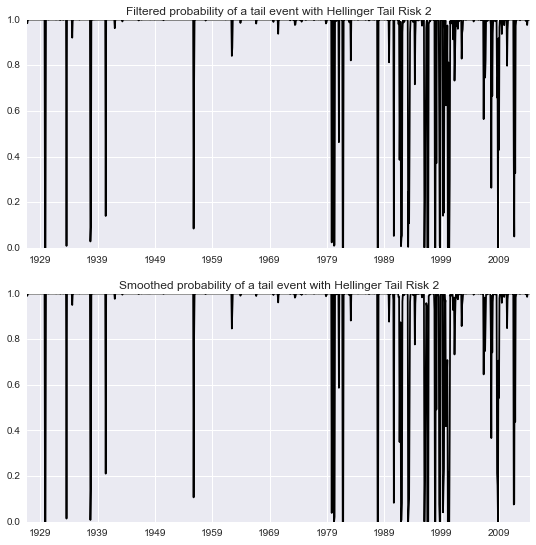

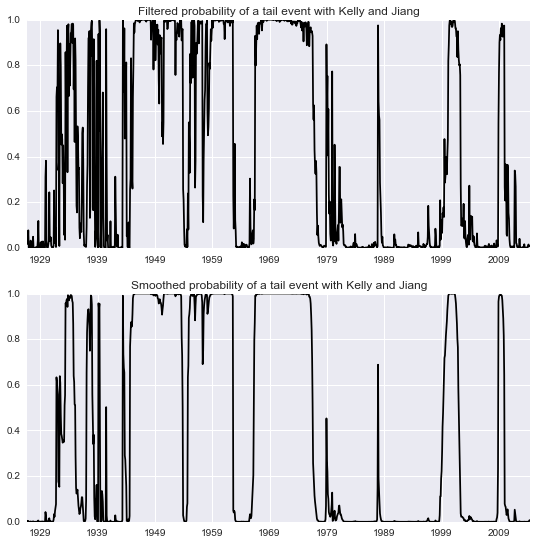

In [5]:
smoothed=pd.DataFrame()
s_var = False
s_mean = True
## Percentage of return
low = .25
high = .75
for data_source,low_mean,high_mean in tail_data.quantile([low,high]).T.itertuples():
    mod = sm.tsa.MAR(tail_data[data_source], order, nstates,switch_var=s_var,switch_mean=s_mean)
    init_trans_prob = np.r_[0.75, 0.25]
    initial_params = np.array(np.r_[
       np.log(init_trans_prob / (1 - init_trans_prob)),  # transition probabilities (transformed)
       0,  # AR parameters is none
       -np.log(1),   # standard deviation (transformed)
       low_mean, high_mean   # Means
    ])

    # Estimate the parameters via MLE
    res = mod.fit(initial_params, method='bfgs');
    params = res.params

    # Transform the unconstrained parameters to interpretable parameters
    final_params = params.copy()
    final_params[0:2] = np.exp(final_params[0:2]) / (1 + np.exp(final_params[0:2])) # transition probabilities
    final_params[3] = np.exp(-final_params[3]) # Standard deviation
    
    print('Parameter Estimates for' + data_source )
    print('-------------------')
    print('Transition probabilities:')
    print(mod.transition_matrix(final_params[0:2]))
    #print('AR Parameters (non-switching, here)')
    #print(final_params[2:6])
    print('Standard Deviation (non-switching, here)')
    print(final_params[-4] * sqrt(12))
    print(final_params[-3] * sqrt(12))
    print('Means (switching)')
    print('- in state 1:', final_params[-2])
    print('- in state 2:', final_params[-1])

    df = pd.DataFrame()
    # Filter the data
    (
        marginal_densities, filtered_joint_probabilities,
        filtered_joint_probabilities_t1
    ) = mod.filter(params);

    transitions = mod.separate_params(params)[0]

    # Smooth the data
    filtered_marginal_probabilities = mod.marginalize_probabilities(filtered_joint_probabilities[1:])
    smoothed_marginal_probabilities = mod.smooth(filtered_joint_probabilities, filtered_joint_probabilities_t1, transitions)

    # Save the data
    df['filtered'] = np.r_[
        [np.NaN]*order,
        filtered_marginal_probabilities[:,0]
    ]
    df['smoothed'] = np.r_[
        [np.NaN]*order,
        smoothed_marginal_probabilities[:,0]
    ]
    smoothed[data_source]=df.smoothed
    import matplotlib.pyplot as plt
    from matplotlib import dates
    fig = plt.figure(figsize=(9,9))

    ax = fig.add_subplot(211)
    ax.plot(tail_data.index, df.filtered, 'k')
    ax.set(
        ylim=(0,1),
        title='Filtered probability of a tail event with ' + data_source
    );

    ax = fig.add_subplot(212)
    ax.plot(tail_data.index, df.smoothed, 'k')
    ax.set(
        ylim=(0,1),
        title='Smoothed probability of a tail event with ' + data_source
    );

In [23]:
X=smoothed.set_index(tail_data.index)
X['T-1']=vol.IV.shift()
X['T-2']=vol.IV.shift(2)
types_vol=['IV','RV','EVRP']
r2_values=[]
for v in types_vol:
    X=smoothed.set_index(tail_data.index)
    X['T-1']=vol[v].shift()
    X['T-2']=vol[v].shift(2)
    X['T-3']=vol[v].shift(3)
    X['T-4']=vol[v].shift(4)
    X['T-5']=vol[v].shift(5)
    X['T-6']=vol[v].shift(6)
    ar6=['T-1','T-2','T-3','T-4','T-5','T-6']    
    r= sm.OLS((vol[v])['1991':'2013'],X['1991':'2013'][ar6]).fit()
    r2_values.append(r.rsquared)    
base_r2 = pd.Series(r2_values,index=types_vol)
types_pred=list(smoothed.columns)
r2={}
beta={}
for v in types_vol:
    r2_values=[]
    b_values=[]
    X=smoothed.set_index(tail_data.index)
    X['T-1']=vol[v].shift()
    X['T-2']=vol[v].shift(2)
    X['T-3']=vol[v].shift(3)
    X['T-4']=vol[v].shift(4)
    X['T-5']=vol[v].shift(5)
    X['T-6']=vol[v].shift(6)
    ar6=['T-1','T-2','T-3','T-4','T-5','T-6']
    for p in types_pred:
        r= sm.OLS((vol[v])['1991':'2013'],X['1991':'2013'][ar6 +[p]]).fit()
        r2_values.append(r.rsquared)
        b_values.append(r.params[p])
    r= sm.OLS((vol[v])['1991':'2013'],X['1991':'2013'][ar6 + types_pred]).fit()
    r2_values.append(r.rsquared)                                       
    r2[v] = pd.Series(r2_values,index=types_pred + ['Kitchen Sink'])
    beta[v] = pd.Series(b_values,index=types_pred)                                       
beta = pd.DataFrame(beta) 
r2 = pd.DataFrame(r2)
improved_r2= r2-base_r2

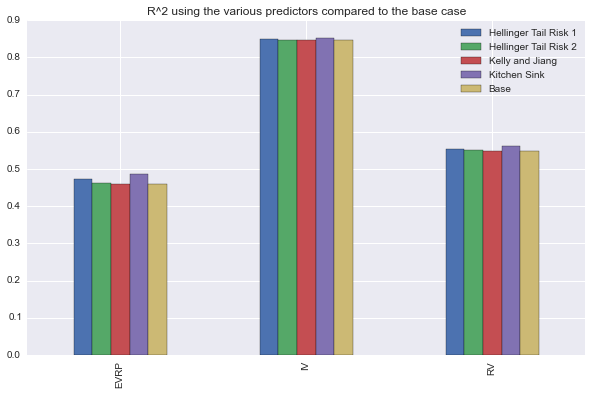

In [24]:
x=r2.T
x['Base']=base_r2
x.plot(kind='bar', title='R^2 using the various predictors compared to the base case')

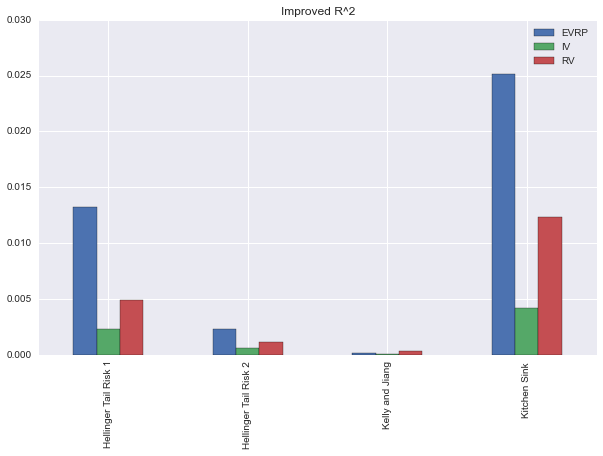

In [25]:
improved_r2.plot(kind='bar',title='Improved R^2')

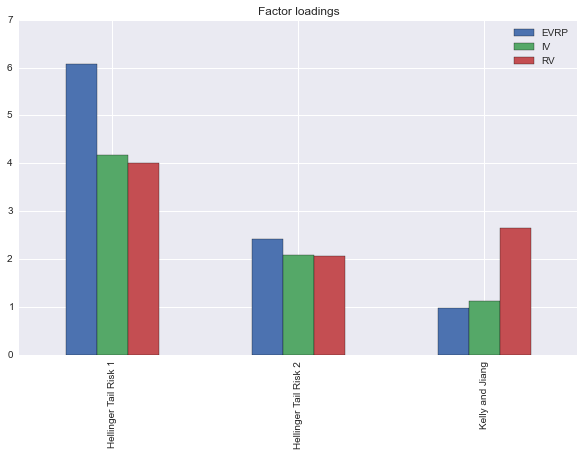

In [26]:
beta.plot(kind='bar',title='Factor loadings')